In [1]:
using Revise
includet("../../scripts/single_influx.jl")

Precompiling packages...
  14352.6 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 17 seconds. 528 already precompiled.


In [2]:
using Base.Threads, OhMyThreads
using ProgressMeter
using BenchmarkTools
using JLD2
using Geppetto
using DataFrames
using DataFramesMeta
using HypothesisTests

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup/util

In [222]:
function paramstring(sep="_", kvsep=""; kwargs...)
    join([(@sprintf "%s%s%.3g" string(n) kvsep v) for (n, v) in kwargs], sep)
end

paramstring (generic function with 3 methods)

In [223]:
function plot_binom_sample!(ax, xs, ns, num_repeats;
        label=""
    )
    if isa(num_repeats, Number)
        num_repeats = fill(num_repeats, length(ns))
    end
    
    sl = scatterlines!(ax, xs, ns; label)

    mins = Float64[]
    maxs = Float64[]
    for (n, nrs) in zip(ns, num_repeats)
        bt = BinomialTest(n, nrs)
        ci = confint(bt; method=:wilson)
        push!(mins, ci[1] * nrs)
        push!(maxs, ci[2] * nrs)
    end

    b = band!(xs, mins, maxs;
        alpha=0.5
    )
    
    (sl, b)
end

plot_binom_sample! (generic function with 1 method)

# Many runs version

In [5]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
        label="bad data"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 1 method)

In [227]:
function plot_df1(df)
    f = Figure(;
        # size=(800, 500)
    )
    
    ax_biom = Axis(f[1,1];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2,1];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3,1];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4,1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"
    
    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)
    
    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )
    
    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )
    
    # display(GLMakie.Screen(), f)
    
    rowgap!(f.layout, 1.)
    plot_cdf1!(ax4, make_counts_df(df))
    axislegend(ax4; position=:lc)

    f
end

plot_df1 (generic function with 1 method)

In [155]:
function plot_df_strain_biomasses(df)
    f = Figure(;
        size=(600, 350)
    )
    ax = Axis(f[1,1];
        xlabel="K",
        ylabel="all strain biomasses",
        xscale=log10,
        yscale=log10,
    )
    
    min_strain_val = minimum(r->minimum(abs, r.steadystates[1:N]), eachrow(df))
    
    for r in eachrow(df)
        scatter!(ax, fill(r.K, N), clamp.(r.steadystates[1:N], min_strain_val, Inf);
            color=Cycled(1),
            marker=:circle
        )
    end
    
    f
end

plot_df_strain_biomasses (generic function with 1 method)

In [386]:
function do_df_run(N;
    M=N,
    lia=10., lib=0.1,
    la=0.1, lb=10.,
    pe=1.,
    nb=M,
    pei=1.,
    Ks=10 .^ range(0., 3.5, 21),
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
)
    pstring = paramstring(; N, M, lia, lib, la, lb, pe, nb, pei)
    
    cms = []
    df = DataFrame(;
        K=Float64[],
        sscode=Int[],
        lscode=Union{Missing,Int}[],
        good_ss=Bool[],
        good_ls=Bool[],
        hss_biomass=Float64[],
        k0mrl=Union{Missing,Float64}[],
        maxmrl=Union{Missing,Float64}[],
        params=Any[],
        steadystates=Vector{Float64}[],
    )
    
    @showprogress for K in Ks
        rsg = JansSampler3(N, M;
            K,
            num_influx_resources=1,
    
            # should be a valid non-dim?
            m=1.,
    
            # first network layer
            prob_eating_influx=pei,
            linflux=Beta(lia, lib),
            cinflux=1.,
            
            # rest of the network
            prob_eating=pe,
            l=Beta(la, lb),
            c=1.,
    
            # rest
            num_byproducts=nb, # applies to both!
    
            Ds=1e-12, Dr=1., Drinflux=1.,
        )
    
        lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
            # zerothr=1000*eps(),
        )
        params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
            maxresidthr=1e-8,
            tol=1e-12,
            doextinctls=true,
            maxiters=1e6,
            timelimit=30,
        )
        
        for i in 1:num_repeats
            sscode = sscodes[i]
            good_ss = (sscode in (1, 2))
            lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
            good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
            push!(df, (
                    K, sscode, lscode, good_ss, good_ls,
                    sum(sss[i][1:N]),
                    !ismissing(lscode) ? lsrslts[i][2] : missing,
                    !ismissing(lscode) ? lsrslts[i][3] : missing,
                    params[i], sss[i]
            ))
        end
    
        codes = Int[]
        for i in 1:num_repeats
            if sscodes[i] == 1
                push!(codes, lsrslts[i][1])
            elseif sscodes[i] == 2
                push!(codes, 101)
            else
                push!(codes, sscodes[i])
            end
        end
        
        cm = countmap(codes)
        push!(cms, cm)
    
        # push!(cms, sscodes)
    end
    
    @show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
    kk = count(df.good_ss .&& df.good_ls) / nrow(df)
    @show kk

    df, cms, pstring
end

do_df_run (generic function with 1 method)

In [ ]:
N = 10
M = N

B = 3
pe = B / M
for la in [0.01, 0.1, 0.3, 0.5, 1., 2., 5., 10.]
    for lb in [0.01, 0.1, 0.3, 0.5, 1., 2., 5., 10.]
        df, cms, pstring = do_df_run(N;
            M,
            lia=10., lib=0.1,
            pei=1.,
            la, lb,
            pe,
            nb=B,
            Ks=10 .^ range(0., 3.5, 21),
            num_repeats=20,
            lsks=10 .^ range(-5, 3, 2000),
        )
        
        f = plot_df1(df)
        Label(f[0,:], pstring; tellwidth=false)
        rowsize!(f.layout, 0, Fixed(0.))
        
        Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
        # Makie.save("../../data/single_influx/gen/last.pdf", f)
    end
end

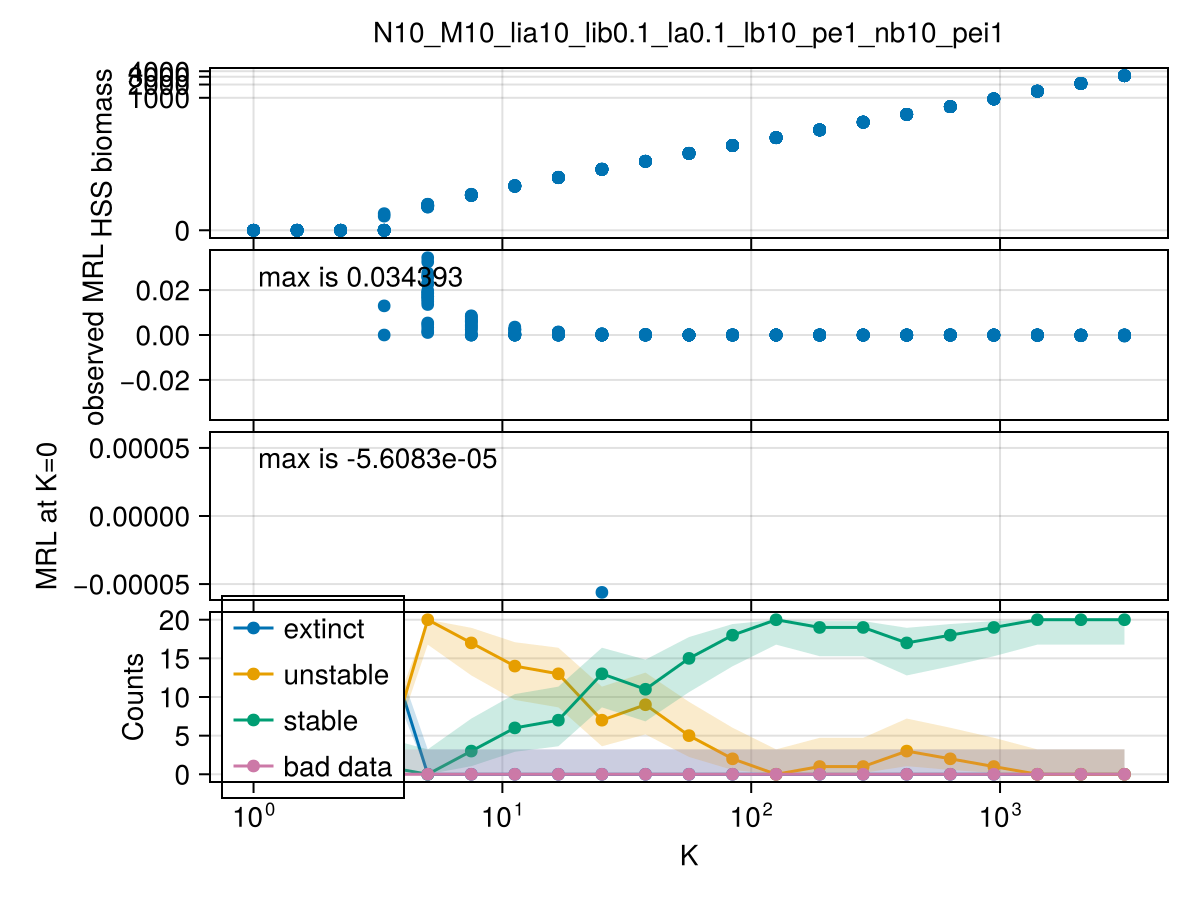

In [389]:
f = plot_df1(df)

Label(f[0,:], pstring; tellwidth=false)
rowsize!(f.layout, 0, Fixed(0.))

# Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
Makie.save("../../data/single_influx/gen/last.pdf", f)

f

# Small changes from Kabirs setup

In [5]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
        label="bad data"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 1 method)

In [227]:
function plot_df1(df)
    f = Figure(;
        # size=(800, 500)
    )
    
    ax_biom = Axis(f[1,1];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2,1];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3,1];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4,1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"
    
    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)
    
    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )
    
    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )
    
    # display(GLMakie.Screen(), f)
    
    rowgap!(f.layout, 1.)
    plot_cdf1!(ax4, make_counts_df(df))
    axislegend(ax4; position=:lc)

    f
end

plot_df1 (generic function with 1 method)

In [155]:
function plot_df_strain_biomasses(df)
    f = Figure(;
        size=(600, 350)
    )
    ax = Axis(f[1,1];
        xlabel="K",
        ylabel="all strain biomasses",
        xscale=log10,
        yscale=log10,
    )
    
    min_strain_val = minimum(r->minimum(abs, r.steadystates[1:N]), eachrow(df))
    
    for r in eachrow(df)
        scatter!(ax, fill(r.K, N), clamp.(r.steadystates[1:N], min_strain_val, Inf);
            color=Cycled(1),
            marker=:circle
        )
    end
    
    f
end

plot_df_strain_biomasses (generic function with 1 method)

In [383]:
N = 10
M = N

Ks = 10 .^ range(0., 3.5, 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
lsks = 10 .^ range(-5, 3, 2000)

lia = 10.
lib = 0.1
pei = 1.

la = 0.1
lb = 10.

B = 3
pe = B / M
nb = B

pstring = paramstring(; N, M, lia, lib, la, lb, pe, nb, pei)

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=pei,
        # linflux=1.,
        linflux=Beta(lia, lib),
        cinflux=1.,
        
        # rest of the network
        prob_eating=pe,
        # l=0.,
        l=Beta(la, lb),
        # l=Beta(0.5, 0.5),
        c=1.,

        # rest
        num_byproducts=nb, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        maxresidthr=1e-8,
        tol=1e-12,
        doextinctls=true,
        maxiters=1e6,
        timelimit=30,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress:  48%|███████████████████▌                     |  ETA: 0:00:10┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.189521 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:13┌ Warning: At t=42629.48120359384, dt was forced below floating point epsilon 7.275957614183426e-12, and step error estimate = 0.004349160548494223. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_

countmap(df.sscode) = Dict(2 => 97, -2000 => 2, 1 => 321)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 193, 1 => 225, missing => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9952380952380953


0.9952380952380953

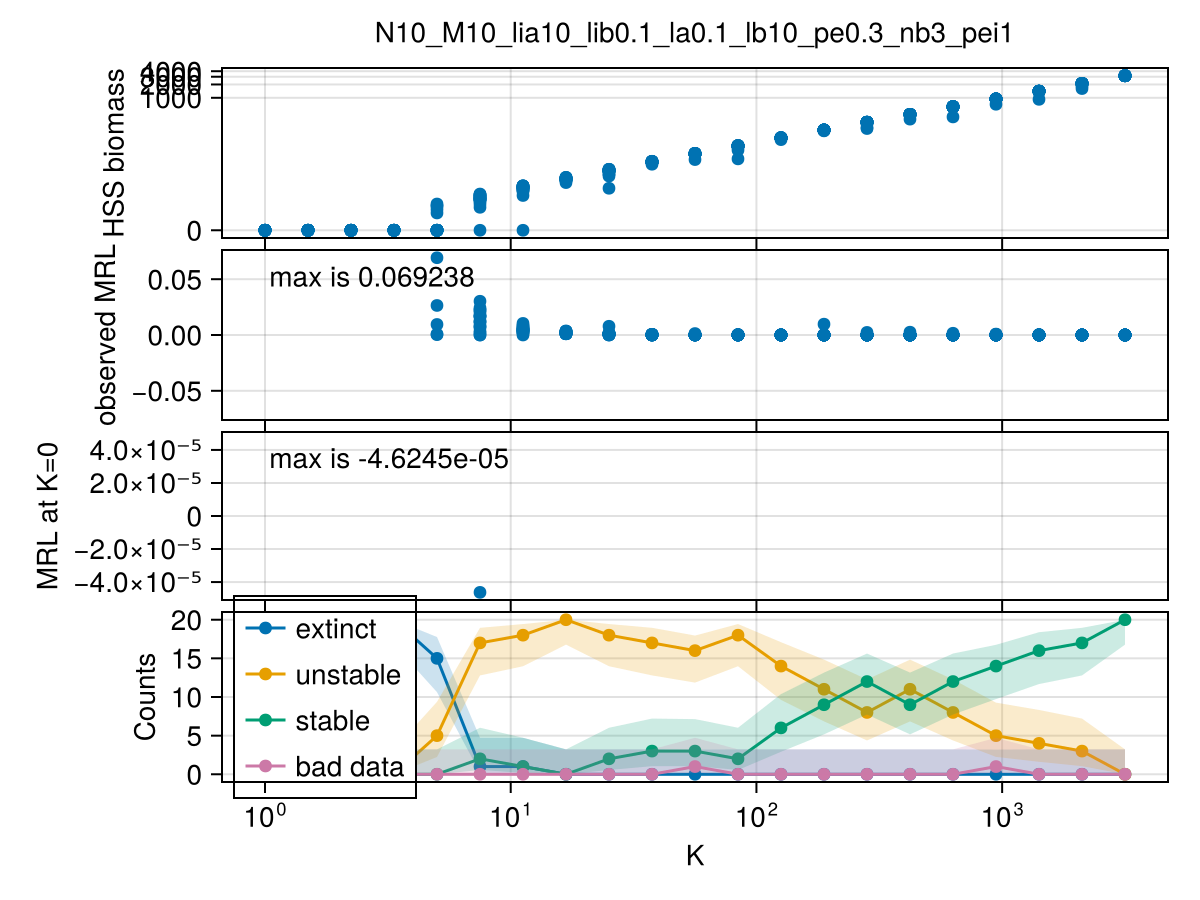

In [385]:
f = plot_df1(df)

Label(f[0,:], pstring; tellwidth=false)
rowsize!(f.layout, 0, Fixed(0.))

Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
Makie.save("../../data/single_influx/gen/last.pdf", f)

f

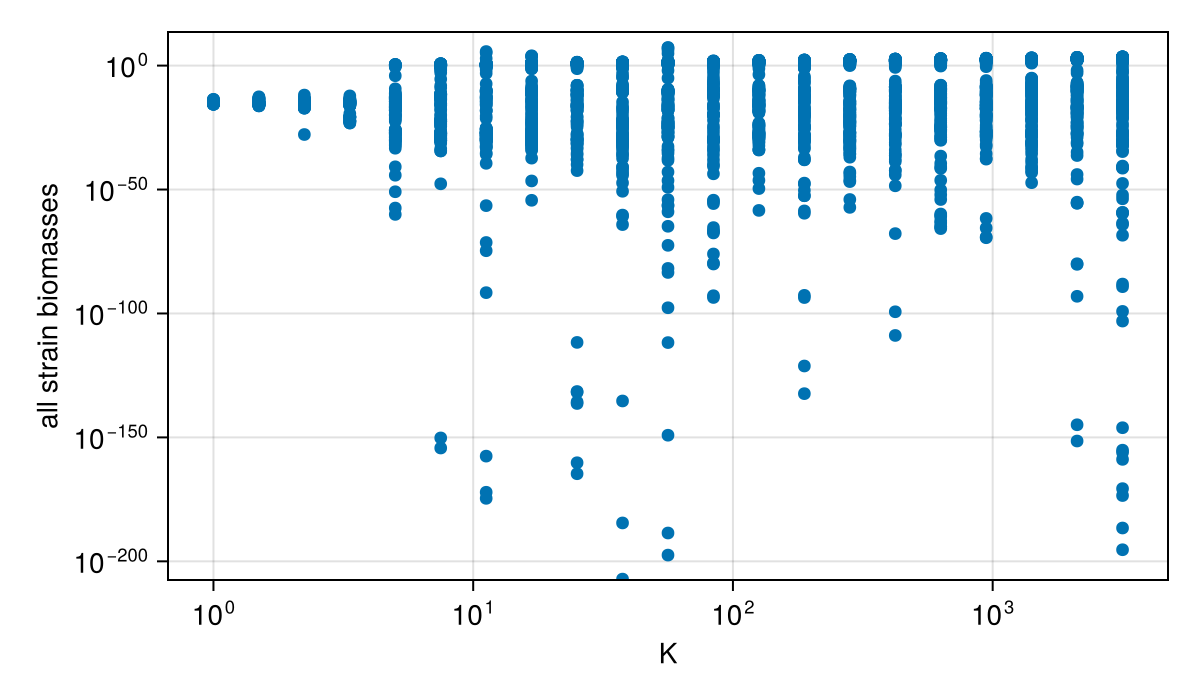

In [289]:
plot_df_strain_biomasses(df)

In [290]:
df.sssurvivors = [count(ss[1:N] .> 1e-8) for ss in df.steadystates];
# scatter(df.sssurvivors, df.lscode)

# Doing exactly Kabirs setup

In [289]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 2 methods)

In [313]:
N = 10
M = N

Ks = 10 .^ range(0., 3., 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
kmax, numks = 50, 1000

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=1.,
        linflux=1.,
        # linflux=Beta(10.,0.01),
        # linflux=Beta(10.,0.1),
        # linflux=Beta(0.5,0.5),
        cinflux=1.,
        
        # rest of the network
        prob_eating=0.1,
        # l=Beta(0.5, 0.5),
        l=0.,
        c=1.,

        # rest
        num_byproducts=4, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, 50., 1000;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        maxresidthr=1e-8,
        tol=1e-13,
        doextinctls=true,
        maxiters=1e5,
        timelimit=10,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress:  33%|█████████████▋                           |  ETA: 0:00:27┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to tim

countmap(df.sscode) = Dict(1015 => 7, 2 => 153, -2000 => 2, 1 => 258)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 23 => 2, 2 => 95, 11 => 24, 12 => 40, 1 => 249, missing => 9)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.819047619047619


0.819047619047619

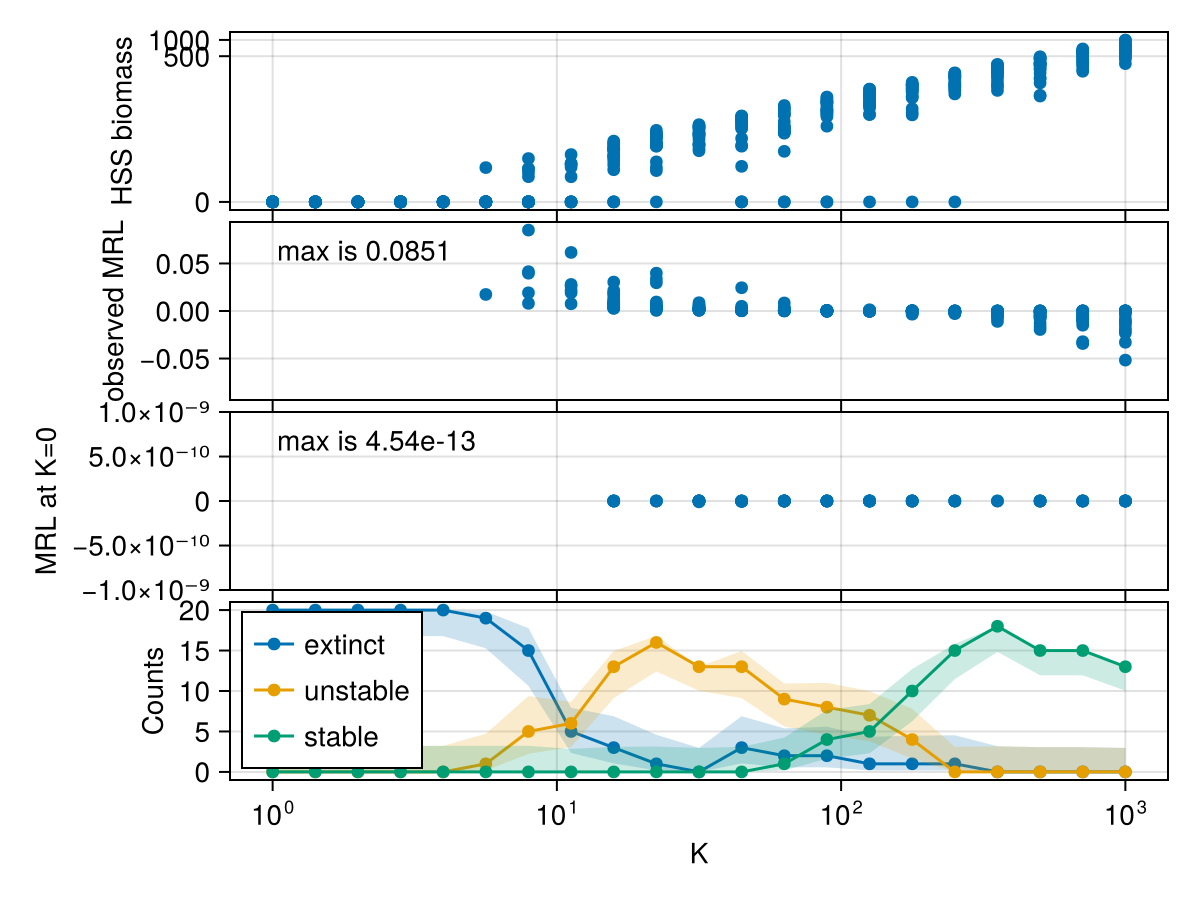

In [314]:
f = Figure(;
    # size=(800, 500)
)

ax_biom = Axis(f[1,1];
    ylabel="HSS biomass",
    yscale=Makie.pseudolog10,
    # yscale=Makie.log10,
    xscale=log10,
)
ax2 = Axis(f[2,1];
    ylabel="observed MRL",
    xscale=log10,
)
ax3 = Axis(f[3,1];
    ylabel="MRL at K=0",
    xscale=log10,
)
ax4 = Axis(f[4,1];
    ylabel="Counts",
    xscale=log10,
)
linkxaxes!(ax_biom, ax4)
linkxaxes!(ax2, ax4)
linkxaxes!(ax2, ax4)
for ax in [ax_biom, ax2, ax3]
    hidexdecorations!(ax;
        grid=false,
        ticks=false,
    )
end
ax4.xlabel = "K"

xx = @subset df :good_ss
# scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
scatter!(ax_biom, xx.K, xx.hss_biomass)

scatter!(ax2, xx.K, xx.maxmrl)
maxmaxmrl = maximum(xx.maxmrl)
ylims!(ax2, (-1.1, 1.1) .* maxmaxmrl)
text!(ax2, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maxmaxmrl),
    space=:relative,
)

scatter!(ax3, xx.K, xx.k0mrl)
text!(ax3, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maximum(xx.k0mrl)),
    space=:relative,
)
ylims!(ax3, (-1, 1) .* 1e-9)

# display(GLMakie.Screen(), f)

rowgap!(f.layout, 1.)
plot_cdf1!(ax4, make_counts_df(df))
axislegend(ax4; position=:lc)

f

# Testing

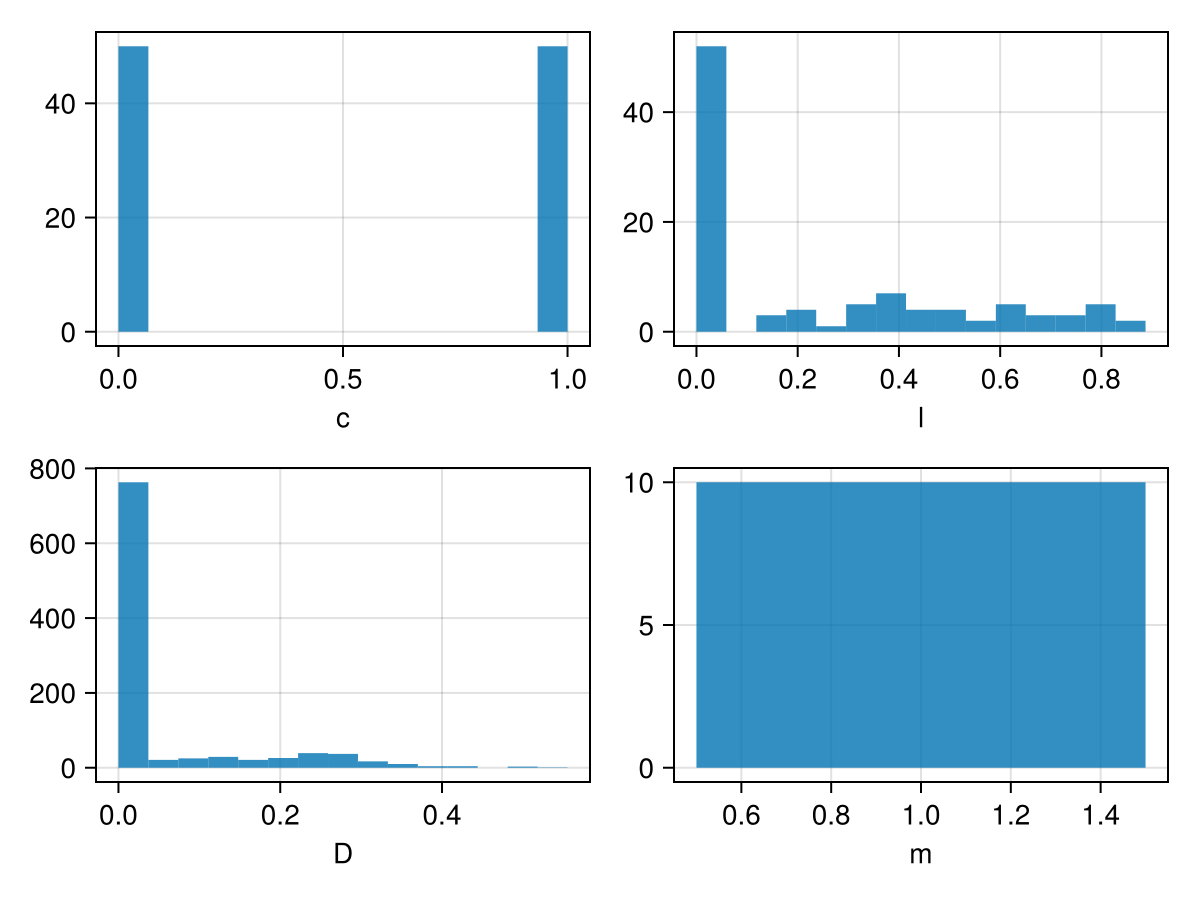

In [7]:
rsg = get_rsg_unimodalc(10;
    K=2,
    # linflux=1.
)

rsg_stats1(rsg)

In [8]:
@time rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

 11.078366 seconds (27.14 M allocations: 5.360 GiB, 3.04% gc time, 1537.87% compilation time: <1% of which was recompilation)


Dict{Int64, Int64} with 2 entries:
  1   => 98
  101 => 2

In [10]:
rsg = JansSampler3(10, 10;
    m=1.,
    K=100.,
    num_influx_resources=1,
    
    prob_eating=0.1,
    num_byproducts=4,
    # l=Beta(0.5, 0.5),
    l=0.,
    c=1.,
    
    prob_eating_influx=1.,
    # linflux=1.,
    linflux=Beta(10.,0.01),
    # linflux=Beta(0.5,0.5),
    cinflux=1.,
)

rsg_stats1(rsg);

In [23]:
instability_stats(cm)

(0.6966292134831461, (0.5946286603942714, 0.7823580914791124))

In [11]:
rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


Dict{Int64, Int64} with 6 entries:
  22    => 8
  101   => 2
  2     => 62
  -1004 => 1
  1     => 25
  23    => 2

# Running a single system

In [108]:
ps = rsg();
# ps = ms();

LoadError: UndefVarError: `rsg` not defined

In [375]:
# i = rand(findall((df.sscode .== 1) .&& isapprox.(df.K, 1.5; atol=0.1)))
# i = rand(findall(df.lscode .=== 2)) # unstable system
# i = rand(findall((df.lscode .=== 1) .&& (df.sscode .== 1))) # nonext stable system
i = rand(findall(df.sscode .== -2000))
dfr = df[i,:]
ps = dfr.params;
dfr

Row,K,sscode,lscode,good_ss,good_ls,hss_biomass,k0mrl,maxmrl,params,steadystates,sssurvivors
,Float64,Int64,Int64?,Bool,Bool,Float64,Float64?,Float64?,Any,Array…,Int64
244,125.893,-2000,missing,false,true,-3.80576e12,missing,missing,"BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 125.893, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.133695 0.0; 0.0 0.0 … 0.315046 0.0; … ; 0.123189 0.0 … 0.39264 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.327626 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.30346; 0.0 0.0 … 0.0 0.0500327; … ; 0.345166 0.0 … 0.0 0.384354; 0.0 0.345869 … 0.0 0.0;;; 0.759052 0.0 … 0.135417 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.882118 0.0798082;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], nothing), [1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nothing, nothing)","[4.01946, 4.81797e-25, 65.1079, -9.62954e-60, -7.88098e-46, 2.41668e-50, 10.2459, 0.000249779, 4.8156e-25, -3.80576e12, 2.57191, -1.16056e7, -1.0904e7, -8.89884e-51, 39.7614, 2.25096e7, 0.51086, 3.80576e12, 4.76358e-47, 0.253581]",4


## No space solver

  0.002923 seconds (779 allocations: 142.625 KiB)


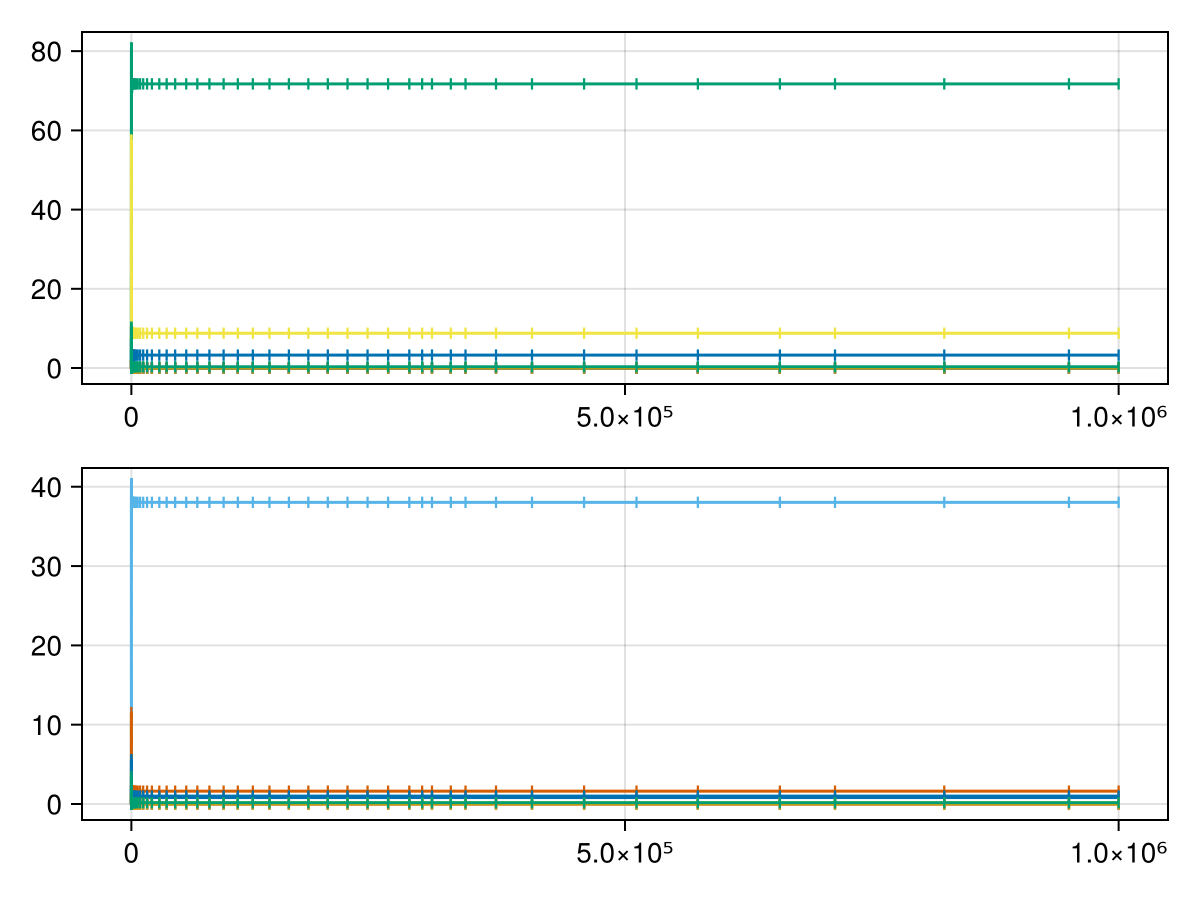

In [377]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000);
# p = remake_guarantee_positive(p)

@time s = solve(p, TRBDF2();
    callback=make_timer_callback(1.)
)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

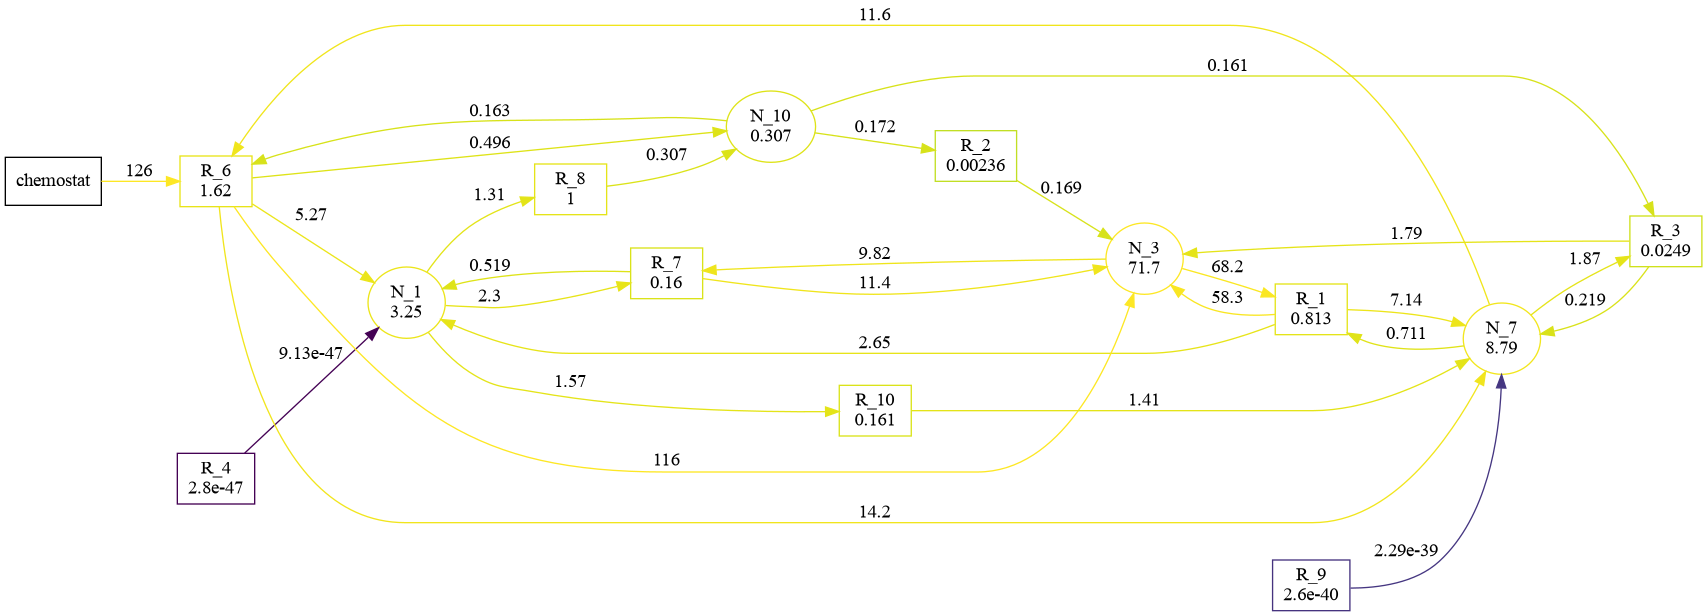

In [378]:
diagram_sfss_v3(ps, clamp.(s.u[end], minimum(abs, s.u[end]), Inf);
    strain_threshold=1e-3,
    colorscale=log10,
)

In [364]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=make_timer_callback(10),
);
maximum(abs, sss.resid)

  1.306676 seconds (3.61 M allocations: 250.990 MiB, 99.96% compilation time)


56.23413251903491

## Spatial stuff

In [379]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 9.592275400649442e-7


### Linear stability

In [380]:
# ks = LinRange(0., 50., 10000)
# ks = lsks
ks = 10 .^ range(-5, 5, 2000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0001301885064772557

In [381]:
xx = LinstabScanTester2(ps, 50., 1000)
xx(ps, nssol)

(2, -0.02617729569943119, 0.0001290439236254262, true)

[ Info: Unstable, mrl is 0.000130189


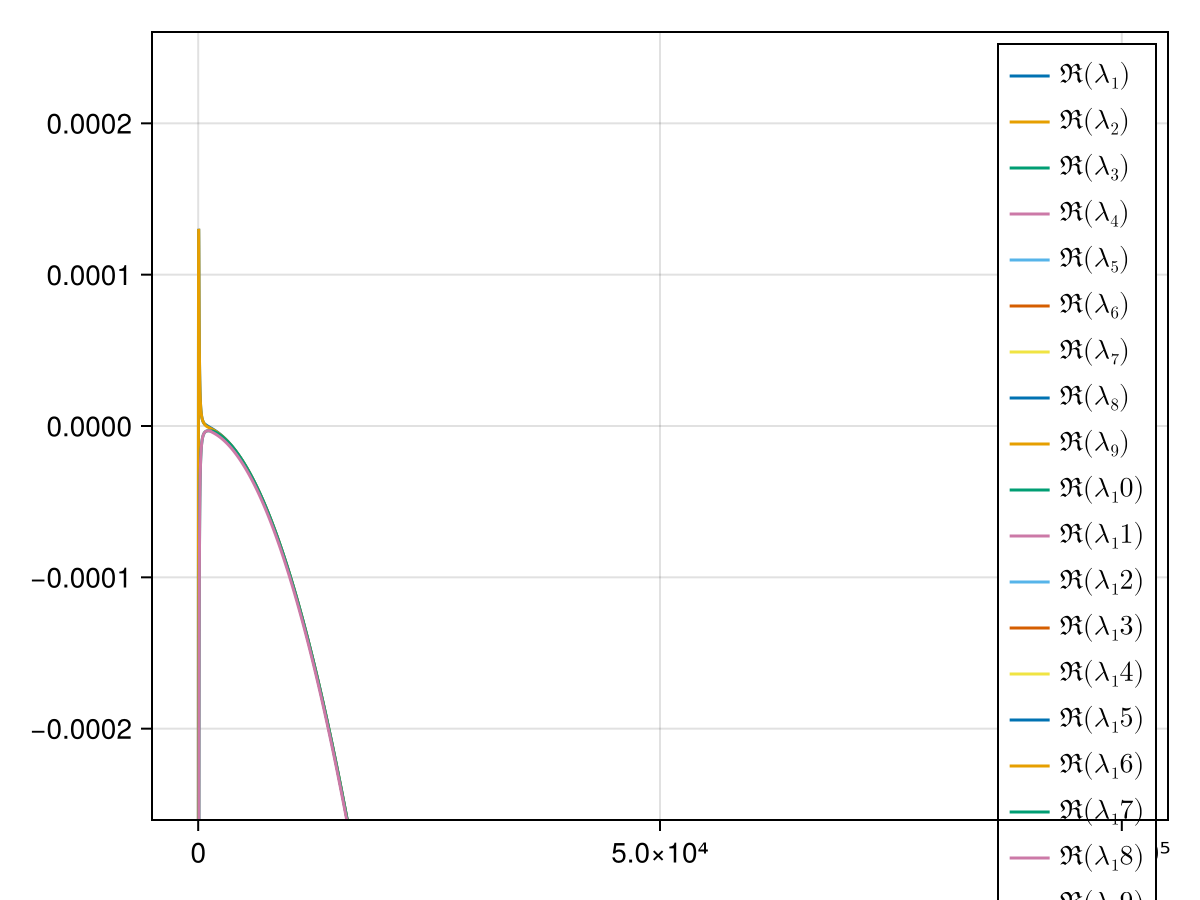

In [382]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
kk = abs(maximum(x->maximum(real, x), lambdas))
ylims!(faa.axis, (-2., 2.) .* kk)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


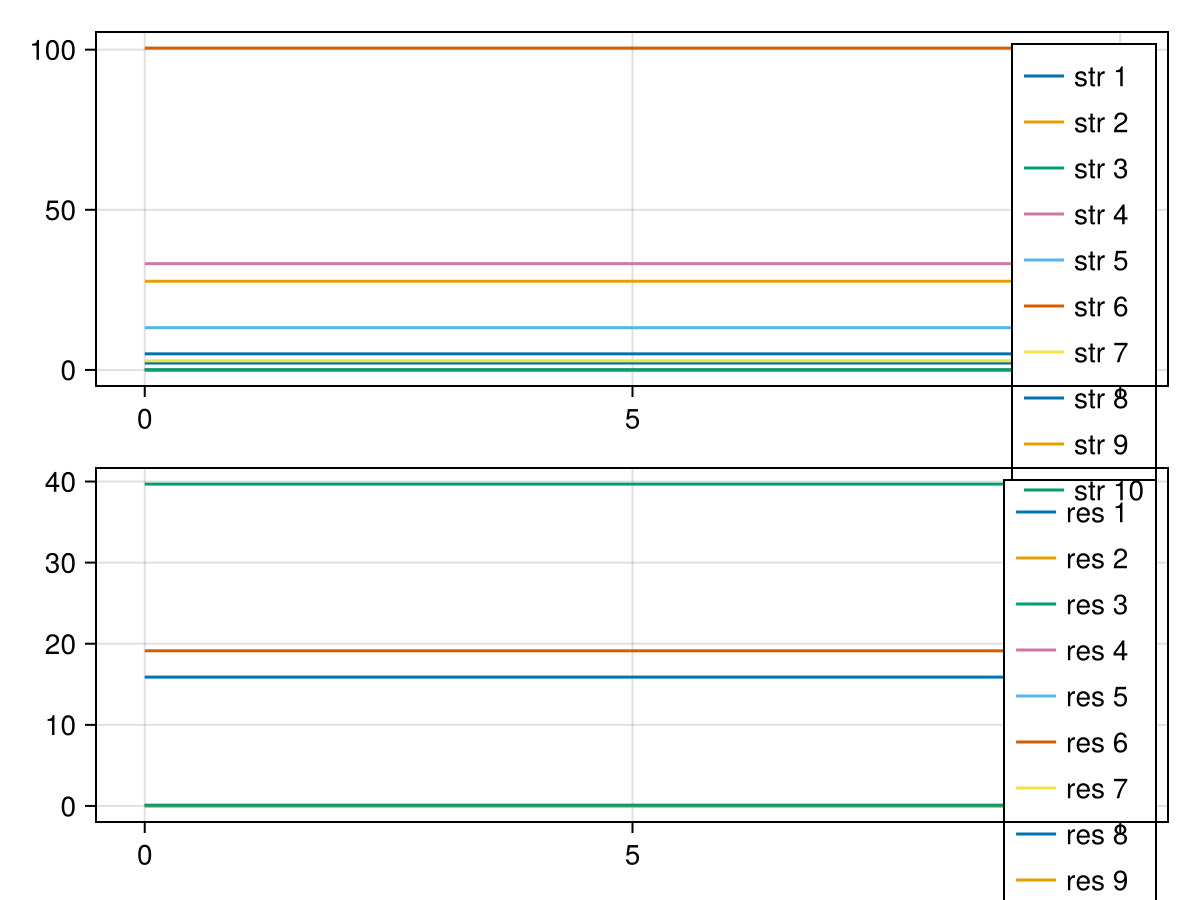

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

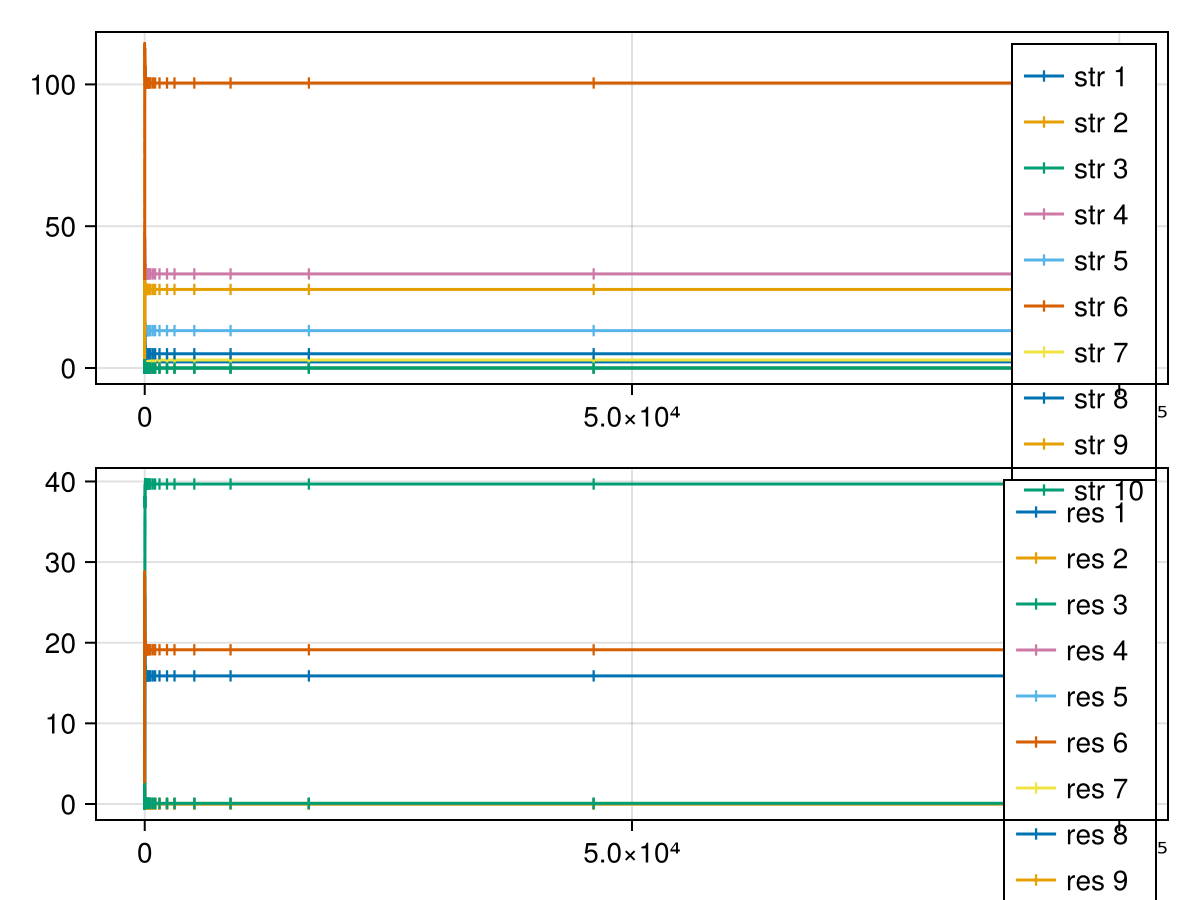

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()